This notebook takes time series of rs-fMRI (nifti format) and returns the best target (MNI coordinates) plus its associated cluster with a vizualisation plot

Input :
- Image (the time series, Nifti format)
- frontal_mask_img (the dlPFC mask you want to use, Nifti format)
- seed_mask_img (the sgACC or any other seed you want to use, Nifti format)

Output :
- best_target : the target in MNI coordinates
- the cluster : 3D numpy array

# 0. Initialization

In [1]:
import nibabel as nib
import numpy as np
import os
import nilearn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import time
from nibabel import imagestats
from nilearn import datasets, plotting, surface, image, masking
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker
from nilearn.surface import vol_to_surf
from nilearn.datasets import get_data_dirs
from nilearn.plotting import plot_epi,plot_roi,show
from plotly import graph_objects as go
from nilearn import plotting, surface, datasets
from nilearn import surface
from nilearn import plotting
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from nilearn.image import mean_img, math_img
from nilearn.plotting import plot_prob_atlas
from matplotlib import patches, ticker
from nilearn import datasets, plotting
from nilearn.image import get_data, index_img, mean_img
from nilearn.regions import Parcellations
from nilearn.plotting import view_img
from scipy.sparse import coo_matrix
import math
from nilearn.masking import compute_epi_mask

# I. Import the image (NIFTI format)

In [2]:
Image = nib.load('Data/RealData/STC_NoGSR_NoSmoothing/raw1_bold_clean-32-parameters.nii')

frontal_mask_img = nib.load('Data/dlPFC_Mask/Julich/MaskJulich_V7.nii') 
seed_mask_img = nib.load('SeedMask.nii') 

In [3]:
# Import real target
Real_Target = np.array([-41, 43, 27]) # for plotting real to optimal 

# II. Give your pipeline

In [4]:
import ClusterFunctions
from sklearn.decomposition import PCA

In [5]:
def Pipeline(brain_time_series,inverted_FCmap,plot_fc_map,noise,verbose) :
    """
    Apply pipeline from the FC_map to the recommended target.
    You can design your own pipeline using the function in "ClusterFunctions"

    Output:
        numpy array: Array with noise added to each time series.
    """
    # CONSENSUS
    #consensus_cluster = ClusterFunctions.extract(inverted_FCmap,niimg,frontal_mask_img,6,verbose = True)
    consensus_cluster = ClusterFunctions.consensus_fwhm(inverted_FCmap,niimg,frontal_mask_img,fwhm1=3,fwhm2=9,verb=True)

    # BAGGING STRATEGY
    bagging_cluster = ClusterFunctions.bagging_overlap(brain_time_series, niimg,frontal_mask_img,brain_masker,SgACC_time_serie,noise,True,fwhm1=3,fwhm2=9,perc=0.7,n=5)
    final_cluster =  bagging_cluster * consensus_cluster
    
    print('Size final cluster : ', np.count_nonzero(final_cluster))
    final_target = ClusterFunctions.get_center(final_cluster,plot_fc_map.affine) #np.mean([best_consensus_target,bagging_best_target],0)
    # Apply PCA to reduce dimensionality
    flattened_arr = final_cluster.reshape(-1, final_cluster.shape[-1])
    pca = PCA(n_components=1)
    reduced_arr = pca.fit_transform(flattened_arr)

    return np.ceil(final_target).astype(int),reduced_arr,final_cluster

# III. RUN PIPELINE

In [6]:
FC_type = 'median' #'mean' #choose the FC-map strategy

In [7]:
niimg = datasets.load_mni152_template()
bin_niimg = nilearn.image.binarize_img(niimg)
SgACC_coords = [(-4,21,-8)]
brain_masker = NiftiMasker(mask_img=frontal_mask_img, smoothing_fwhm=1, detrend=True, 
            standardize='zscore_sample', low_pass=0.1, high_pass=0.01, t_r=2, verbose=0)
seed_masker = NiftiMasker(mask_img=seed_mask_img, smoothing_fwhm=1, detrend=True, 
            standardize='zscore_sample', low_pass=0.1, high_pass=0.01, t_r=2, verbose=0)

/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/image.py:1066: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Smoothing :  6
0.012128369167447084


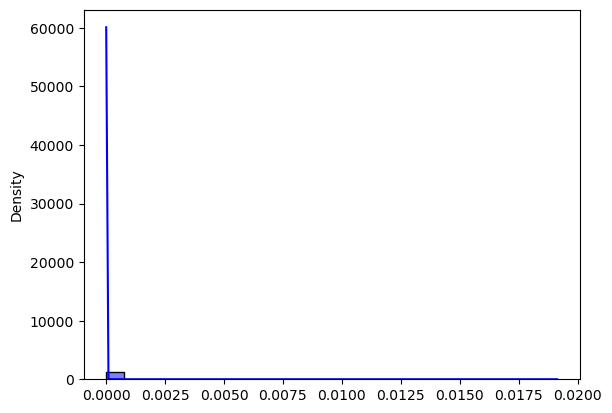

Thr = 0.012128369167447084
Cluster size :  1094
> 0 :  1094 Max :  0.01912836916744709
< 0 :  0 Min :  0.0
Size final cluster :  1094
[-25  49  32]


In [8]:
SgACC_time_series= seed_masker.fit_transform(Image)
SgACC_time_serie = np.median(SgACC_time_series, axis=1).reshape(-1, 1)

brain_time_series = brain_masker.fit_transform(Image)
if FC_type == 'median':
    correlation_matrix = SgACC_time_serie * brain_time_series
    flatten_fc_map = np.median(correlation_matrix, axis=0).reshape(-1, 1)
elif FC_type == 'mean':
    flatten_fc_map = (np.dot(brain_time_series.T, SgACC_time_serie) / SgACC_time_serie.shape[0]) # ! renversée

inverted_fc_map = brain_masker.inverse_transform(-flatten_fc_map.T)
real_fc_map = brain_masker.inverse_transform(flatten_fc_map.T) # not inverted values
# APPLY PIPELINE ON DATA

expected_target,_,final_cluster = Pipeline(brain_time_series,inverted_fc_map,real_fc_map,False,False)


print(expected_target)


/var/folders/kr/wpd5gn_j78n7c_8gvk8flkgr0000gn/T/ipykernel_19786/964542412.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


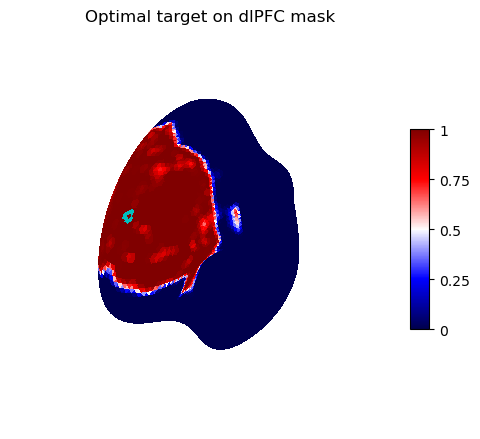

In [9]:
#Plot the target on the dlPFC mask
fsaverage = datasets.fetch_surf_fsaverage()
curv_left = surface.load_surf_data(fsaverage.curv_left)
curv_left_sign = np.sign(curv_left)
texture = surface.vol_to_surf(frontal_mask_img, fsaverage.pial_left)

pial = fsaverage.pial_left
coord = np.array([-41, 43, 27])

mesh_coords = np.array(nib.load(pial).darrays[0].data)

diff = mesh_coords - expected_target
sq_distance = np.sum(diff**2, 1)
closest = np.argsort(sq_distance)[:3]
parcellation = np.zeros(texture.shape)
parcellation[closest] = 1

fig = plotting.plot_surf_stat_map(surf_mesh = fsaverage.infl_left, stat_map=texture,hemi='left', view=[10.0, 120.0],title='Optimal target on dlPFC mask',engine = 'matplotlib', cmap = 'seismic')
fig_finale=plotting.plot_surf_contours(fsaverage.infl_left, parcellation, labels=['roi'], levels=[1], figure=fig, legend=False, colors=['c'])
fig_finale.show()


/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/juliantalou/NeuroSPIN/ClusterFunctions.py:438: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_finale.show()


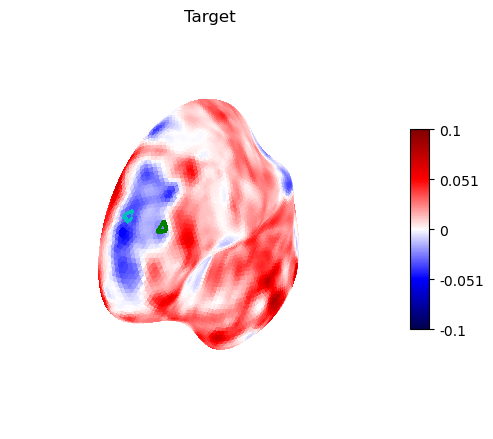

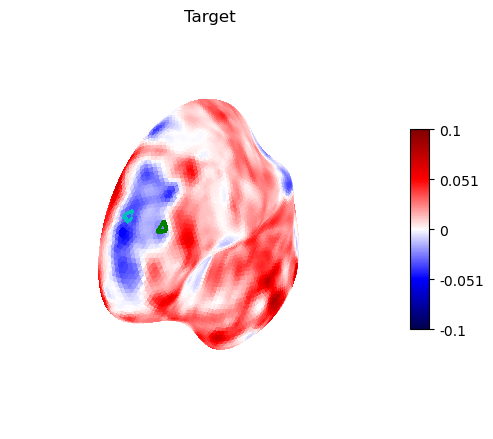

In [11]:
# Plot target (cyan) and Cash (green) on the FC-map
all_brain_masker = NiftiMasker(mask_img=bin_niimg, smoothing_fwhm=3, detrend=True, 
            standardize='zscore_sample', low_pass=0.1, high_pass=0.01, t_r=2, verbose=0)
all_brain_time_series = all_brain_masker.fit_transform(Image)
all_correlation_matrix = SgACC_time_serie * all_brain_time_series
all_flatten_fc_map = np.median(all_correlation_matrix, axis=0).reshape(-1, 1)
all_real_fc_map = all_brain_masker.inverse_transform(all_flatten_fc_map.T)
ClusterFunctions.plot_real_to_cash(all_real_fc_map,niimg,expected_target,'seismic','Target')